In [9]:
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, autoguide
import jax.numpy as jnp
from jax import random
import arviz as az
import optax  # Optimizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset

In [2]:
# Load the dataset
file_path = "dataverse_files/1-Fragment_C_Hole_Measurements.csv"
df = pd.read_csv(file_path)

# Extract coordinates and section info
measured_x = df['Mean(X)'].values
measured_y = df['Mean(Y)'].values
sections = df['Section ID'].values

# Write the NumPyro Model

## Hole Index to Section Mapping
Note that we have ignored hole_index = 0 in Section 0 and hole_index = 69 in Section 4

| Hole Index | sec_id | Original Section |
|------------|--------|------------------|
| 1 - 22     | 0      | 1                |
| 23 - 31    | 1      | 2                |
| 32 - 68    | 2      | 3                |
| 70 - 72    | 3      | 5                |
| 73 - 74    | 4      | 6                |
| 75 - 80    | 5      | 7                |

In [3]:
def model(x, y, num_sections=6):

    # Define priors
    N_original = numpyro.sample('N', dist.Uniform(340, 370))  # Continuous parameter
    r = numpyro.sample('r', dist.Uniform(70, 85))
    sigma = numpyro.sample('sigma', dist.Uniform(0.01, 0.2))
    
    x0 = numpyro.sample('x0', dist.Normal(80, 3), sample_shape=(num_sections,))
    y0 = numpyro.sample('y0', dist.Normal(135, 2), sample_shape=(num_sections,))
    alpha = numpyro.sample('alpha', dist.Normal(-145, 2), sample_shape=(num_sections,))
    alpha_rad = jnp.deg2rad(alpha)

    # Define likelihood function
    for i in range(len(x)):
        if i == 0 or i == 69:
            continue
        
        original_sec_id = sections[i]
        if original_sec_id == 1:
            sec_id = 0
        elif original_sec_id == 2:
            sec_id = 1
        elif original_sec_id == 3:
            sec_id = 2
        elif original_sec_id == 5:
            sec_id = 3
        elif original_sec_id == 6:
            sec_id = 4
        elif original_sec_id == 7:
            sec_id = 5

        # angle of hole i in radian
        phi = 2 * jnp.pi * i / N_original + alpha_rad[sec_id] # note the slight difference from paper, because hole index starts from 0 in the code

        # Predicted position
        mx = r * jnp.cos(phi) + x0[sec_id]
        my = r * jnp.sin(phi) + y0[sec_id]
        
        # Transform error into local radial/tangential coordinates
        dx = x[i] - mx
        dy = y[i] - my
        
        # Independent Gaussian noise in the radial/tangential frame and multiplied together
        numpyro.sample(
            f'obs_{i}',
            dist.MultivariateNormal(
                loc=jnp.array([0.0, 0.0]),
                covariance_matrix=jnp.diag(jnp.array([sigma**2, sigma**2]))
            ),
            obs=jnp.array([dx, dy])
        )

# Run the MCMC

In [4]:
rng_key = random.PRNGKey(3)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000, num_chains=2)
mcmc.run(rng_key, x=measured_x, y=measured_y, num_sections=6)
samples = mcmc.get_samples()

/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_3942/339531168.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000, num_chains=2)
sample: 100%|██████████| 15000/15000 [49:07<00:00,  5.09it/s, 127 steps of size 1.50e-02. acc. prob=0.91]  


# Extract results

In [5]:
posterior = az.from_numpyro(mcmc)
summary = az.summary(posterior)
print(summary)

             mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
N         355.172  2.566  350.336  360.065      0.039    0.026    4303.0   
alpha[0] -145.709  0.156 -145.993 -145.404      0.002    0.001   10126.0   
alpha[1] -145.659  0.515 -146.616 -144.684      0.005    0.004   11000.0   
alpha[2] -145.556  0.371 -146.258 -144.857      0.006    0.004    4453.0   
alpha[3] -145.504  1.343 -148.010 -142.943      0.013    0.010   10380.0   
alpha[4] -145.089  1.437 -147.663 -142.296      0.014    0.011   10744.0   
alpha[5] -146.968  0.946 -148.740 -145.197      0.010    0.007    8521.0   
r          77.320  0.553   76.282   78.372      0.008    0.006    4296.0   
sigma       0.095  0.006    0.084    0.106      0.000    0.000   20969.0   
x0[0]      79.672  0.410   78.880   80.421      0.006    0.004    4783.0   
x0[1]      79.874  0.643   78.667   81.076      0.006    0.005   10436.0   
x0[2]      79.864  0.095   79.682   80.039      0.001    0.001   10724.0   
x0[3]      7

/Users/zhimeiliu/Downloads/DIS/dis_sheet/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='N'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n5'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='N', ylabel='r'>, <Axes: xlabel='alpha\n0'>,
        <Axes: xlabel='alpha\n1'>, <Axes: xlabel='alpha\n2'>,
        <Axes: xlabel='alpha\n3'>, <Axes: xlabel='alpha\n4'>,
        <Axes: xla

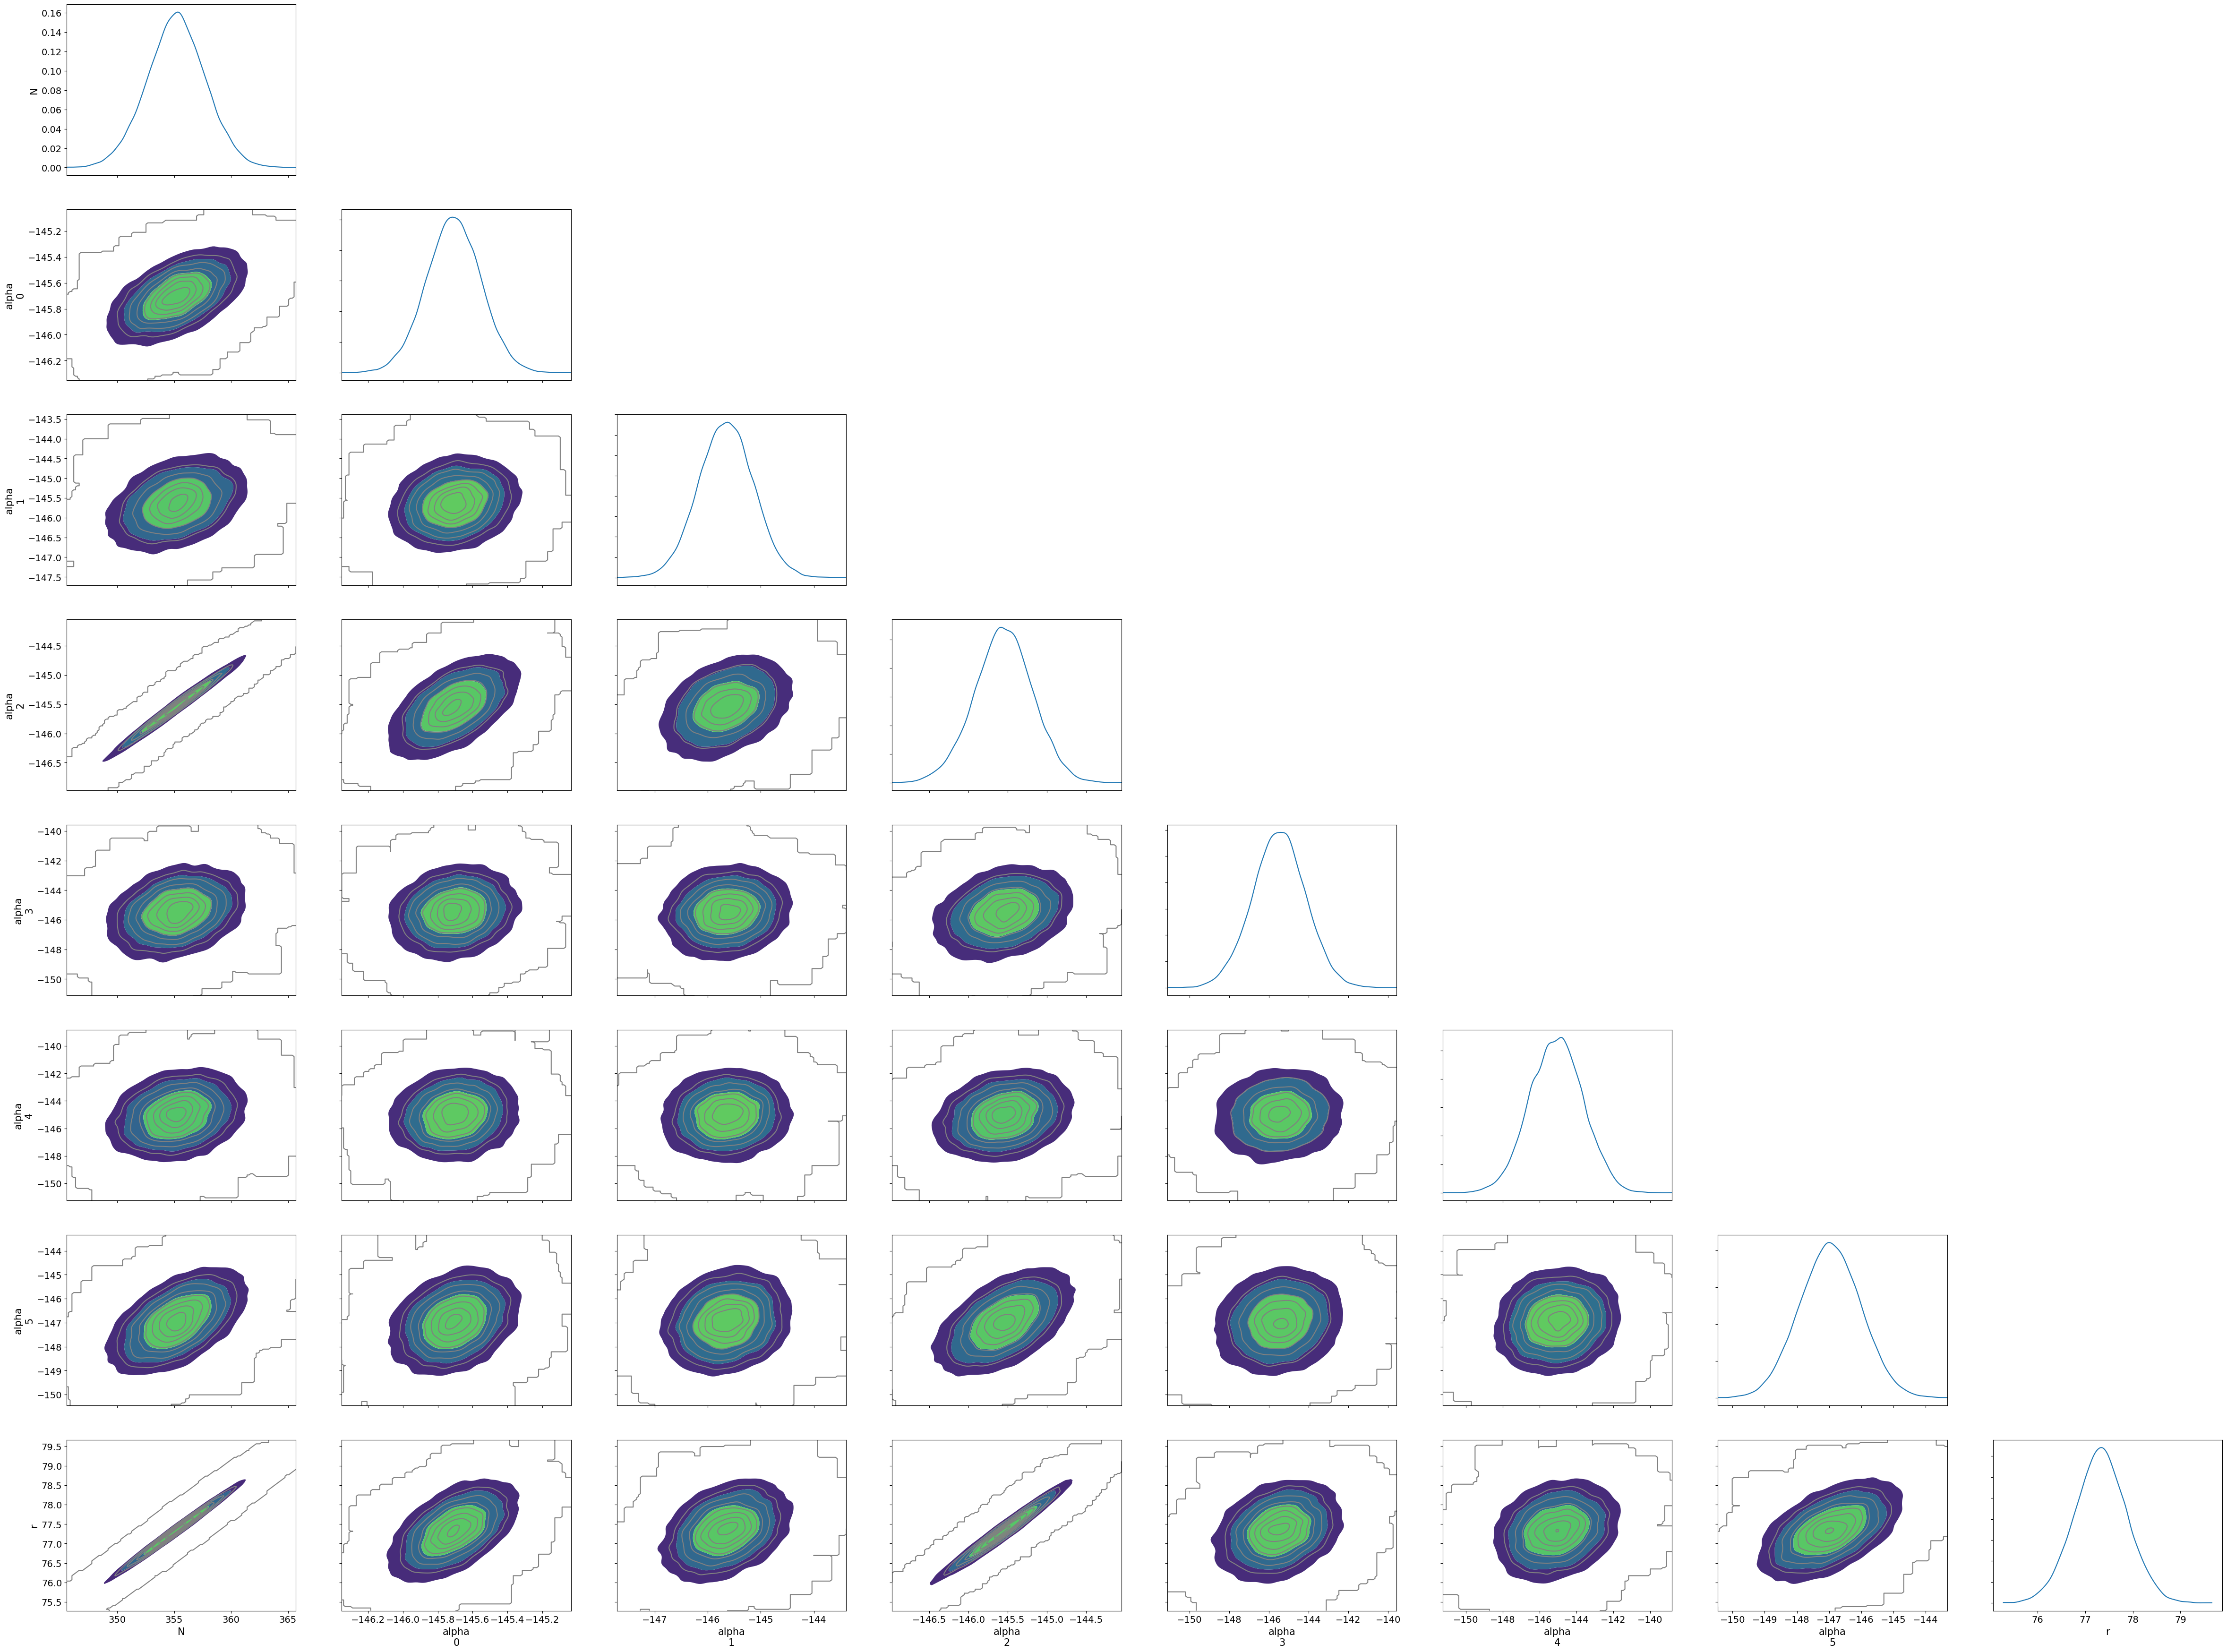

In [6]:
az.plot_pair(posterior, kind='kde', marginals=True)

# Find MLE

In [7]:
# Define a guide (variational approximation)
guide = autoguide.AutoDelta(model)  # AutoDelta finds MLE

# Set up optimizer and SVI inference
optimizer = optax.adam(0.01)  # Learning rate = 0.01
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Run optimization (use previous random key)
svi_result = svi.run(rng_key, 10000, x=measured_x, y=measured_y, num_sections=6)  # 10,000 optimization steps

# Extract MLE estimates
mle_params = guide.median(svi_result.params)

# Convert MLE estimates to a dictionary for pandas
mle_dict = {
    "Parameter": ["N", "r", "sigma"] + [f"x0[{i}]" for i in range(6)] + [f"y0[{i}]" for i in range(6)] + [f"alpha[{i}]" for i in range(6)],
    "Value": [
        float(mle_params['N']),
        float(mle_params['r']),
        float(mle_params['sigma']),
        *mle_params['x0'].tolist(),
        *mle_params['y0'].tolist(),
        *mle_params['alpha'].tolist()
    ]
}

# Create DataFrame
df_mle = pd.DataFrame(mle_dict)

# Print table
print(df_mle)

100%|██████████| 10000/10000 [00:12<00:00, 832.85it/s, init loss: 78379.1406, avg. loss [9501-10000]: -121.3544]


   Parameter       Value
0          N  355.278076
1          r   77.343948
2      sigma    0.088620
3      x0[0]   79.687668
4      x0[1]   79.904831
5      x0[2]   79.867271
6      x0[3]   79.892128
7      x0[4]   79.919014
8      x0[5]   82.235641
9      y0[0]  136.062607
10     y0[1]  135.723648
11     y0[2]  135.706345
12     y0[3]  135.670624
13     y0[4]  135.305908
14     y0[5]  136.044754
15  alpha[0] -145.703064
16  alpha[1] -145.664993
17  alpha[2] -145.539001
18  alpha[3] -145.508759
19  alpha[4] -145.068192
20  alpha[5] -147.015060


# Plot predicted hole locations from MLE

In [17]:
# Extract MLE parameter values
N_mle = float(mle_params["N"])  
r_mle = float(mle_params["r"])  
x0_mle = mle_params["x0"]  
y0_mle = mle_params["y0"]  
alpha_mle = np.deg2rad(mle_params["alpha"])

# Compute predicted hole locations
predicted_x, predicted_y = [], []
for i, (_, row) in enumerate(df.iterrows()):
    original_sec = int(row["Section ID"])
    
    if original_sec == 0 or original_sec == 4:
        mx = row["Mean(X)"]
        my = row["Mean(Y)"]
    else:
        if original_sec == 1:
            sec_id = 0
        elif original_sec == 2:
            sec_id = 1
        elif original_sec == 3:
            sec_id = 2
        elif original_sec == 5:
            sec_id = 3
        elif original_sec == 6:
            sec_id = 4
        elif original_sec == 7:
            sec_id = 5
        
        phi = (2 * np.pi * i / N_mle) + alpha_mle[sec_id]

        mx = r_mle * np.cos(phi) + x0_mle[sec_id]
        my = r_mle * np.sin(phi) + y0_mle[sec_id]

    predicted_x.append(mx)
    predicted_y.append(my)

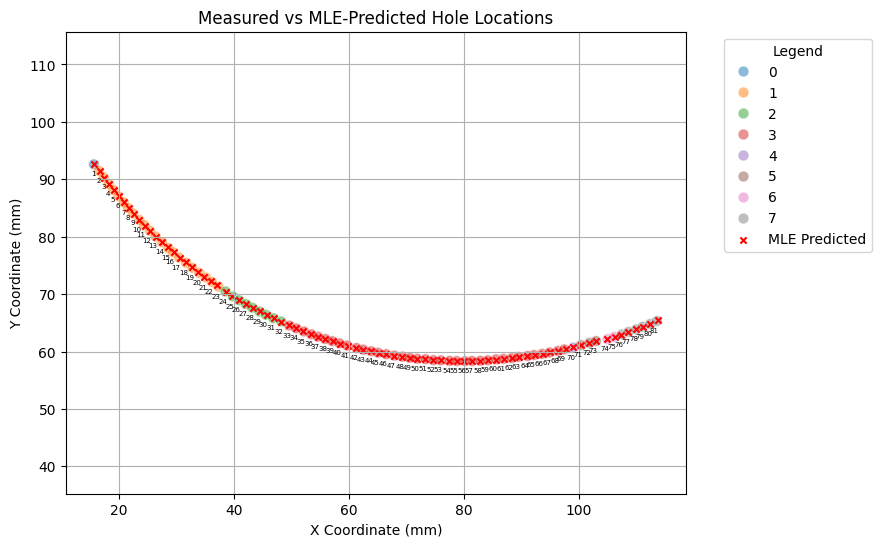

In [26]:
plt.figure(figsize=(8, 6))

# Plot measured hole locations
sns.scatterplot(data=df, x="Mean(X)", y="Mean(Y)", hue="Section ID", palette="tab10", s=60, alpha=0.5)

# Plot predicted hole locations from MLE
plt.scatter(predicted_x, predicted_y, color="red", marker="x", s=20, label="MLE Predicted")

# Annotate each hole number
for i, row in df.iterrows():
    plt.text(row["Mean(X)"] + 0.3, row["Mean(Y)"] - 2, str(int(row["Hole"])), fontsize=5, ha='right')

# Labels and formatting
plt.xlabel("X Coordinate (mm)")
plt.ylabel("Y Coordinate (mm)")
plt.title("Measured vs MLE-Predicted Hole Locations")
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis("equal")
plt.grid(True)

# Show plot
plt.show()

# Sample posterior with HMC

In [ ]:
chosen_hole_id = 10  
hole_index = df[df["Hole"] == chosen_hole_id].index[0]  # Get DataFrame row index

# Extract section ID for this hole
original_sec_id = df.loc[hole_index, "Section ID"]

# Convert original section ID to mapped sec_id
sec_id_map = {1: 0, 2: 1, 3: 2, 5: 3, 6: 4, 7: 5}
sec_id = sec_id_map.get(original_sec_id, None)

# Ensure sec_id is valid
if sec_id is None:
    raise ValueError(f"Invalid section ID {original_sec_id} for hole {chosen_hole_id}")

# Extract posterior samples for parameters
N_posterior = samples["N"]
r_posterior = samples["r"]
x0_posterior = samples["x0"][:, sec_id]  # Section-specific x0
y0_posterior = samples["y0"][:, sec_id]  # Section-specific y0
alpha_posterior = np.deg2rad(samples["alpha"][:, sec_id])  # Convert to radians
sigma_posterior = samples["sigma"]  # Measurement noise

# Compute posterior predictive positions
posterior_x, posterior_y = [], []
for i in range(len(N_posterior)):  # Loop over posterior samples
    phi = (2 * np.pi * (chosen_hole_id - 1) / N_posterior[i]) + alpha_posterior[i]
    mx = r_posterior[i] * np.cos(phi) + x0_posterior[i]
    my = r_posterior[i] * np.sin(phi) + y0_posterior[i]
    
    # Introduce measurement noise (Gaussian perturbation)
    mx += np.random.normal(0, sigma_posterior[i])
    my += np.random.normal(0, sigma_posterior[i])
    
    posterior_x.append(mx)
    posterior_y.append(my)


In [ ]:
# Create figure
plt.figure(figsize=(8, 6))

# Plot measured hole locations
sns.scatterplot(data=df, x="Mean(X)", y="Mean(Y)", hue="Section ID", palette="tab10", s=60)

# Plot MLE-predicted hole locations (from your previous MLE calculations)
plt.scatter(predicted_x, predicted_y, color="red", marker="x", s=60, label="MLE Predicted")

# Plot posterior predictive distribution for the chosen hole
plt.scatter(posterior_x, posterior_y, color="blue", alpha=0.2, marker="o", s=10, label="Posterior Predictive")

# Highlight the chosen hole's measured location
hole_x = df.loc[hole_index, "Mean(X)"]
hole_y = df.loc[hole_index, "Mean(Y)"]
plt.scatter([hole_x], [hole_y], color="black", marker="*", s=100, label="Measured Hole 10")

# Labels and formatting
plt.xlabel("X Coordinate (mm)")
plt.ylabel("Y Coordinate (mm)")
plt.title(f"Measured vs Posterior Predictive for Hole {chosen_hole_id}")
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis("equal")
plt.grid(True)

# Show plot
plt.show()
